<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/PredictiveModel_LSTM_08122024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [335]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Needed Libraries

In [336]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

import optuna
from optuna.integration import TFKerasPruningCallback

# Data Cleaning & Merging

## Search Sheet

In [337]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Sheet

In [338]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Sheet

In [339]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [340]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

In [341]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## CPI

In [342]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## SPX

In [343]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## NASDAQ

In [344]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## DJIA

In [345]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-345-884830d5858d>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



## Foreign Exchange Rate

In [346]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

## PPI

In [347]:
ppi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [114.8, 117, 119.3, 121.2, 133.576, 141.286, 142.683],
    'Feb': [115.1, 117.2, 118.6, 122, 134.821, 141.237, 143.509],
    'Mar': [115.3, 117.6, 118, 122.8, 137.041, 140.738, 143.410],
    'Apr': [115.5, 118.2, 116.6, 124.1, 137.805, 140.977, 144.119],
    'May': [115.9, 118.3, 117.2, 125.3, 139.026, 140.664, 144.079],
    'Jun': [116.3, 118.2, 117.5, 126.2, 140.238, 140.672, 144.402],
    'Jul': [116.4, 118.5, 118.2, 127.504, 139.837, 141.461, None],
    'Aug': [116.5, 118.6, 118.4, 128.574, 139.721, 142.353, None],
    'Sep': [116.7, 118.3, 118.7, 129.188, 140.137, 142.658, None],
    'Oct': [117.5, 118.8, 119.4, 130.061, 140.666, 142.191, None],
    'Nov': [117.4, 118.6, 119.5, 131.455, 141.18, 142.267, None],
    'Dec': [117.4, 119, 120, 132.224, 140.696, 142.17, None]
}

# Converting PPI data to DataFrame
ppi_df = pd.DataFrame(ppi_data)

# Melting the PPI DataFrame to long format
ppi_long_df = pd.melt(ppi_df, id_vars=['Year'], var_name='Month', value_name='PPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
ppi_long_df['Month'] = ppi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
ppi_long_df['Day'] = 1

# Creating a date column in the PPI DataFrame
ppi_long_df['Date'] = pd.to_datetime(ppi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
ppi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
ppi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known PPI value of each month
ppi_long_df = ppi_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
ppi_long_df.reset_index(inplace=True)

ppi_long_df['Date'] = pd.to_datetime(ppi_long_df['Date'])
df_merged7 = pd.merge(df_merged6, ppi_long_df[['Date', 'PPI']], on='Date', how='inner')

## Unemployment Rate

In [348]:
unemp_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [4, 4, 3.6, 6.4, 4, 3.4, 3.7],
    'Feb': [4.1, 3.8, 3.5, 6.2, 3.8, 3.6, 3.9],
    'Mar': [4, 3.8, 4.4, 6.1, 3.6, 3.5, 3.8],
    'Apr': [4, 3.7, 14.8, 6.1, 3.7, 3.4, 3.9],
    'May': [3.8, 3.6, 13.2, 5.8, 3.6, 3.7, 4],
    'Jun': [4, 3.6, 11, 5.9, 3.6, 3.6, 4.1],
    'Jul': [3.8, 3.7, 10.2, 5.4, 3.5, 3.5, None],
    'Aug': [3.8, 3.6, 8.4, 5.1, 3.6, 3.8, None],
    'Sep': [3.7, 3.5, 7.8, 4.7, 3.5, 3.8, None],
    'Oct': [3.8, 3.6, 6.8, 4.5, 3.6, 3.8, None],
    'Nov': [3.8, 3.6, 6.7, 4.1, 3.6, 3.7, None],
    'Dec': [3.9, 3.6, 6.7, 3.9, 3.5, 3.7, None]
}

# Converting Unempl data to DataFrame
unemp_df = pd.DataFrame(unemp_data)

# Melting the Unempl DataFrame to long format
unemp_long_df = pd.melt(unemp_df, id_vars=['Year'], var_name='Month', value_name='Unemployment')

# Maunempng month names to numbers
month_maunempng = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
unemp_long_df['Month'] = unemp_long_df['Month'].map(month_maunempng)

# Creating a 'Day' column with value 1 for each row
unemp_long_df['Day'] = 1

# Creating a date column in the Unempl DataFrame
unemp_long_df['Date'] = pd.to_datetime(unemp_long_df[['Year', 'Month', 'Day']])

# Drounempng unnecessary columns
unemp_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
unemp_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known Unempl value of each month
unemp_long_df = unemp_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
unemp_long_df.reset_index(inplace=True)

unemp_long_df['Date'] = pd.to_datetime(unemp_long_df['Date'])
df_merged8 = pd.merge(df_merged7, unemp_long_df[['Date', 'Unemployment']], on='Date', how='inner')

## Overnight Reverse Repo Facility (RRP)

In [349]:
rrp_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Additional data/RRPONTSYD.csv'
df = pd.read_csv(rrp_path)
df = df.rename(columns={'DATE': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged9 = pd.merge(df_merged8, df, on='Date', how='inner')

## Fed Security Holdings

In [350]:
security_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Additional data/WSHOSHO.csv'
df = pd.read_csv(security_path)
df = df.rename(columns={'DATE': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)
# Resample the weekly data to daily frequency, using forward fill to fill in the missing days
df = df.resample('D').ffill()

df_merged10 = pd.merge(df_merged9, df, on='Date', how='inner')

In [351]:
df_merged10

,Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),...,"JAPAN -- SPOT EXCHANGE RATE, YEN/US$",PPI,Unemployment,RRPONTSYD,WSHOSHO
0,2024-06-21,BGCR,5.30,5.25,5.30,...,159.4500,144.402,4.1,421.04,6810058.0
1,2024-06-20,BGCR,5.31,5.25,5.31,...,158.7700,144.402,4.1,388.841,6810058.0
2,2024-06-18,BGCR,5.32,5.25,5.32,...,157.8100,144.402,4.1,375.542,6818650.0
3,2024-06-17,BGCR,5.32,5.26,5.31,...,157.8000,144.402,4.1,333.429,6818650.0
4,2024-06-14,BGCR,5.30,5.25,5.30,...,157.2800,144.402,4.1,386.885,6818650.0
...,...,...,...,...,...,...,...,...,...,...,...
1551,2018-04-06,BGCR,1.70,1.60,1.70,...,107.0300,115.500,4.0,4.895,4171790.0
1552,2018-04-05,BGCR,1.70,1.60,1.70,...,107.4800,115.500,4.0,4.645,4171790.0
1553,2018-04-04,BGCR,1.70,1.57,1.70,...,106.5600,115.500,4.0,4.57,4171790.0
1554,2018-04-03,BGCR,1.81,1.50,1.80,...,106.4500,115.500,4.0,8.695,4183642.0


## Probability of rate hike/cut



In [352]:
hikecut_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Additional data/Bloomberg data - WIRP AUG8 2024.csv'
df = pd.read_csv(hikecut_path)
df = df.rename(columns={'Data': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged11 = pd.merge(df_merged10, df, on='Date', how='inner')

## Consolidated df

In [353]:
df_final = df_merged11.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

,Rate (%),Volume ($Billions),LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),...,PPI,Unemployment,RRPONTSYD,WSHOSHO,#Hikes/Cuts
Date,,,,,,,,,,,
2018-04-02,1.77,361,2.90,2.85,0.41,...,115.500,4.0,3.823,4183642.0,0.012
2018-04-03,1.81,344,2.96,2.90,0.39,...,115.500,4.0,8.695,4183642.0,0.023
2018-04-04,1.70,348,2.97,2.91,0.39,...,115.500,4.0,4.57,4171790.0,0.001
2018-04-05,1.70,349,3.01,2.95,0.41,...,115.500,4.0,4.645,4171790.0,0.012
2018-04-06,1.70,352,2.94,2.89,0.39,...,115.500,4.0,4.895,4171790.0,0.001
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,5.30,785,4.42,4.46,-0.29,...,144.402,4.1,386.885,6818650.0,-0.120
2024-06-17,5.32,772,4.48,4.52,-0.23,...,144.402,4.1,333.429,6818650.0,-0.080
2024-06-18,5.32,763,4.43,4.47,-0.20,...,144.402,4.1,375.542,6818650.0,-0.100


In [354]:
df_final2 = df_final2.apply(pd.to_numeric, errors='coerce')

In [355]:
# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_final2.isna().sum())

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_final2[cols] = df_final2[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_final2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

# Preliminary EDA

In [356]:
print(df_final2.describe())

          Rate (%)  Volume ($Billions)  LT COMPOSITE (>10 Yrs)  \
count  1541.000000         1541.000000             1541.000000   
mean      2.119896          449.541856                2.862362   
std       1.939072          103.794554                1.086422   
min       0.010000          303.000000                0.970000   
25%       0.060000          369.000000                1.980000   
50%       1.870000          415.000000                2.920000   
75%       3.770000          496.000000                3.780000   
max       5.350000          794.000000                5.280000   

       TREASURY 20-Yr CMT  Yield Spread (4W - 52W)  ...          PPI  \
count         1541.000000              1541.000000  ...  1541.000000   
mean             2.855730                 0.229384  ...   128.467530   
std              1.116531                 0.499733  ...    10.774362   
min              0.870000                -1.020000  ...   115.500000   
25%              1.980000                -0.0

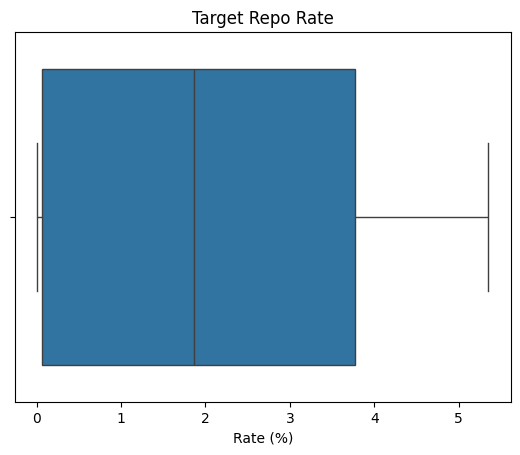

In [357]:
# Visualization using boxplot
sns.boxplot(x=df_final2['Rate (%)'])
plt.title('Target Repo Rate')
plt.show()

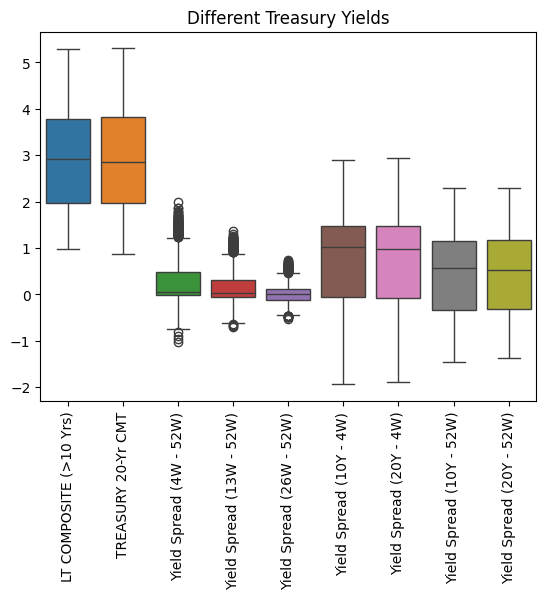

In [358]:
columns_to_plot = [
    "LT COMPOSITE (>10 Yrs)",
    "TREASURY 20-Yr CMT",
    "Yield Spread (4W - 52W)",
    "Yield Spread (13W - 52W)",
    "Yield Spread (26W - 52W)",
    "Yield Spread (10Y - 4W)",
    "Yield Spread (20Y - 4W)",
    "Yield Spread (10Y - 52W)",
    "Yield Spread (20Y - 52W)"
]

# Create the boxplot for the selected columns
sns.boxplot(data=df_final2[columns_to_plot])
plt.title('Different Treasury Yields')
plt.xticks(rotation=90)
plt.show()

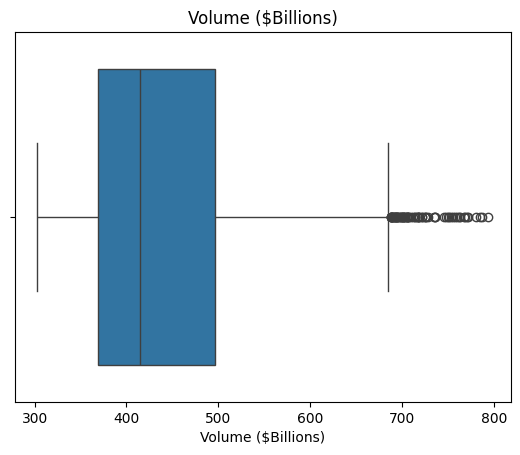

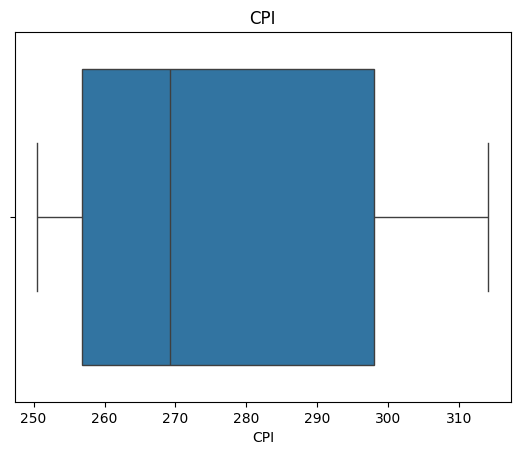

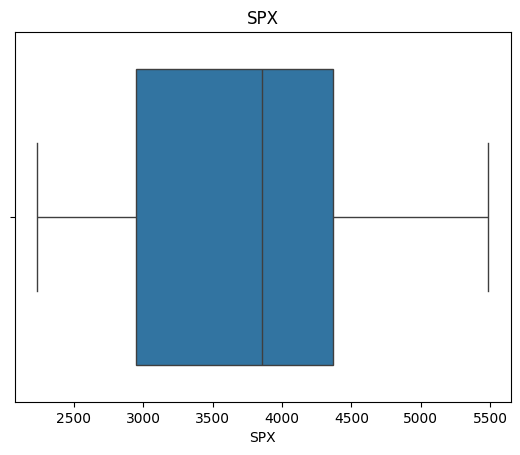

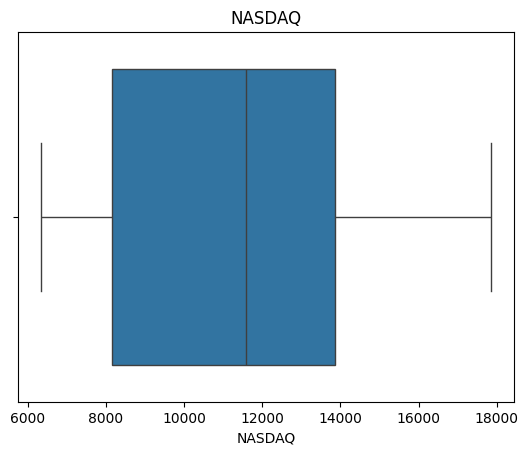

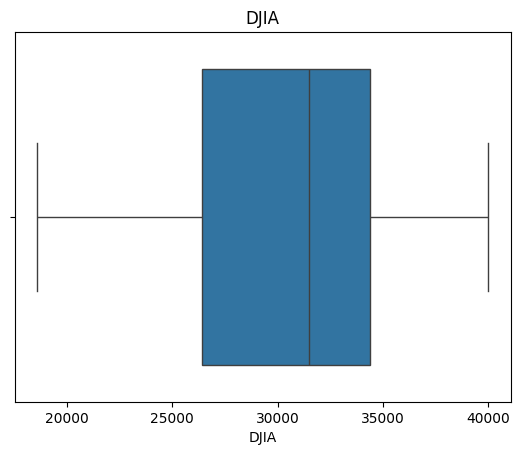

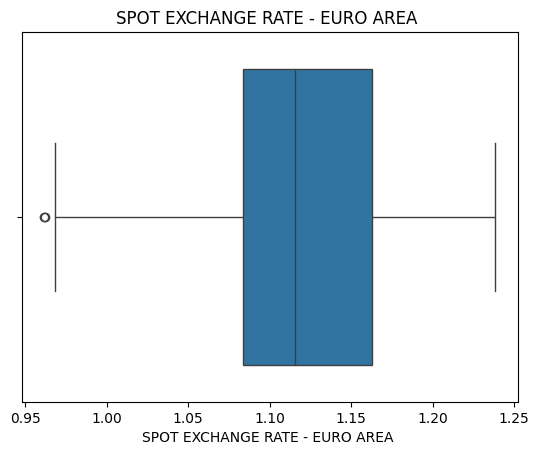

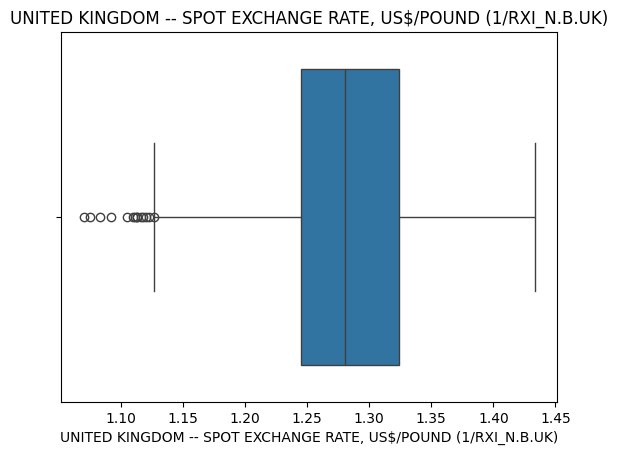

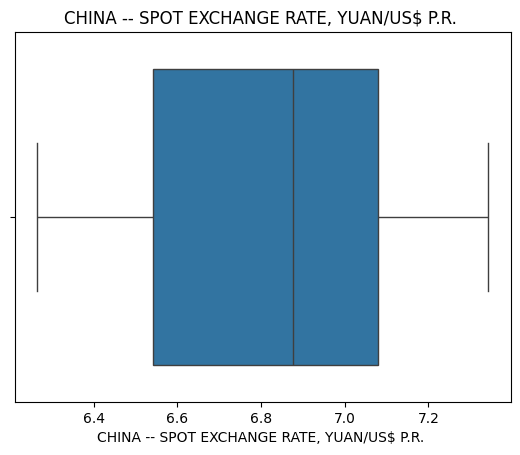

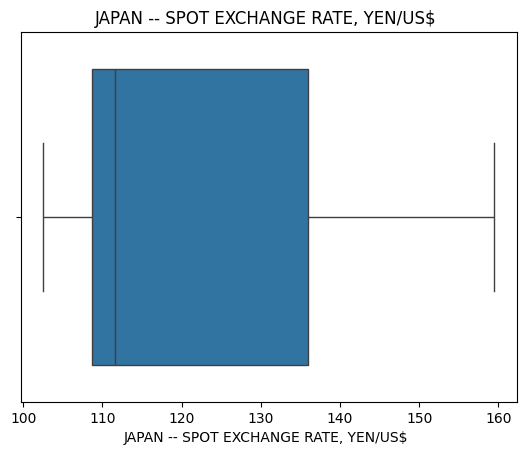

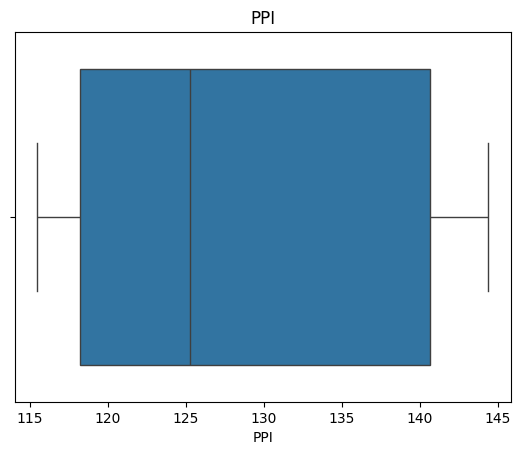

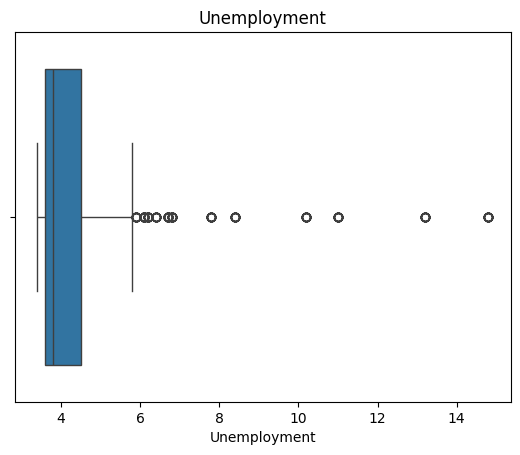

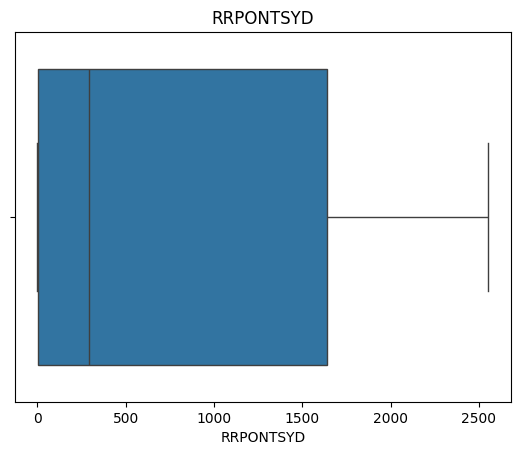

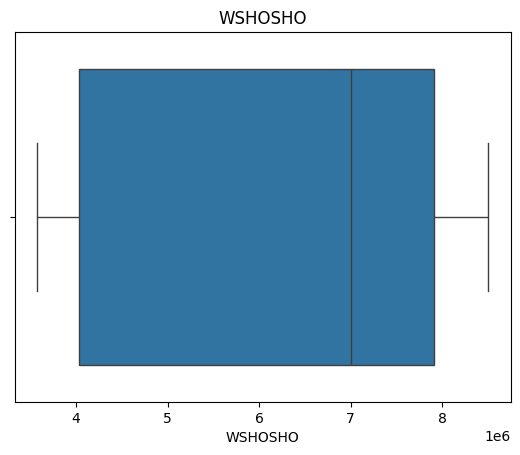

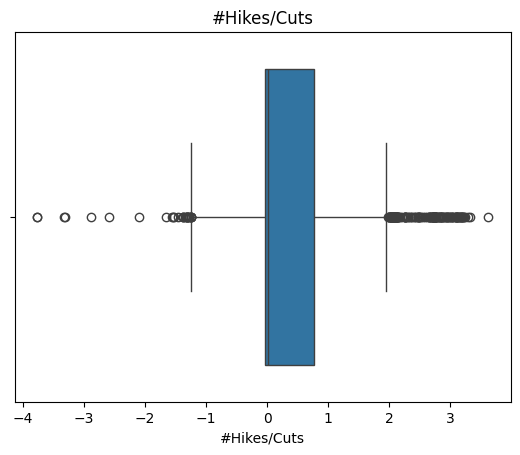

In [359]:
# List of columns to plot
columns_to_plot = [
    "Volume ($Billions)",
    "CPI",
    "SPX",
    "NASDAQ",
    "DJIA",
    "SPOT EXCHANGE RATE - EURO AREA ",
    "UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)",
    "CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ",
    "JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ",
    "PPI",
    "Unemployment",
    "RRPONTSYD",
    "WSHOSHO",
    "#Hikes/Cuts"
]

# Loop through each column and plot
for column in columns_to_plot:
    sns.boxplot(x=df_final2[column])
    plt.title(column)
    plt.show()

# Train / Test Split

In [360]:
# Split into train and test

train = df_final2[:'2022-12-31']
test = df_final2['2023-01-01':]

In [361]:
# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Examine Potential Co-Linearity

In [362]:
# Combine X and y into a single dataframe for simplicity
data = pd.concat([X_train, y_train], axis =1)

# Calculate correlation matrix
corr = data.corr()

# Display correlation matrix
pd.set_option('display.max_columns', 10)
print(corr)

                                                    Volume ($Billions)  \
Volume ($Billions)                                            1.000000   
LT COMPOSITE (>10 Yrs)                                       -0.019030   
TREASURY 20-Yr CMT                                           -0.070915   
Yield Spread (4W - 52W)                                      -0.408014   
Yield Spread (13W - 52W)                                     -0.443036   
Yield Spread (26W - 52W)                                     -0.492711   
Yield Spread (10Y - 4W)                                      -0.731090   
Yield Spread (20Y - 4W)                                      -0.748049   
Yield Spread (10Y - 52W)                                     -0.463900   
Yield Spread (20Y - 52W)                                     -0.515183   
CPI                                                          -0.423308   
SPX                                                          -0.629784   
NASDAQ                                

<ipython-input-363-2e03a7c0e7f5>:14: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



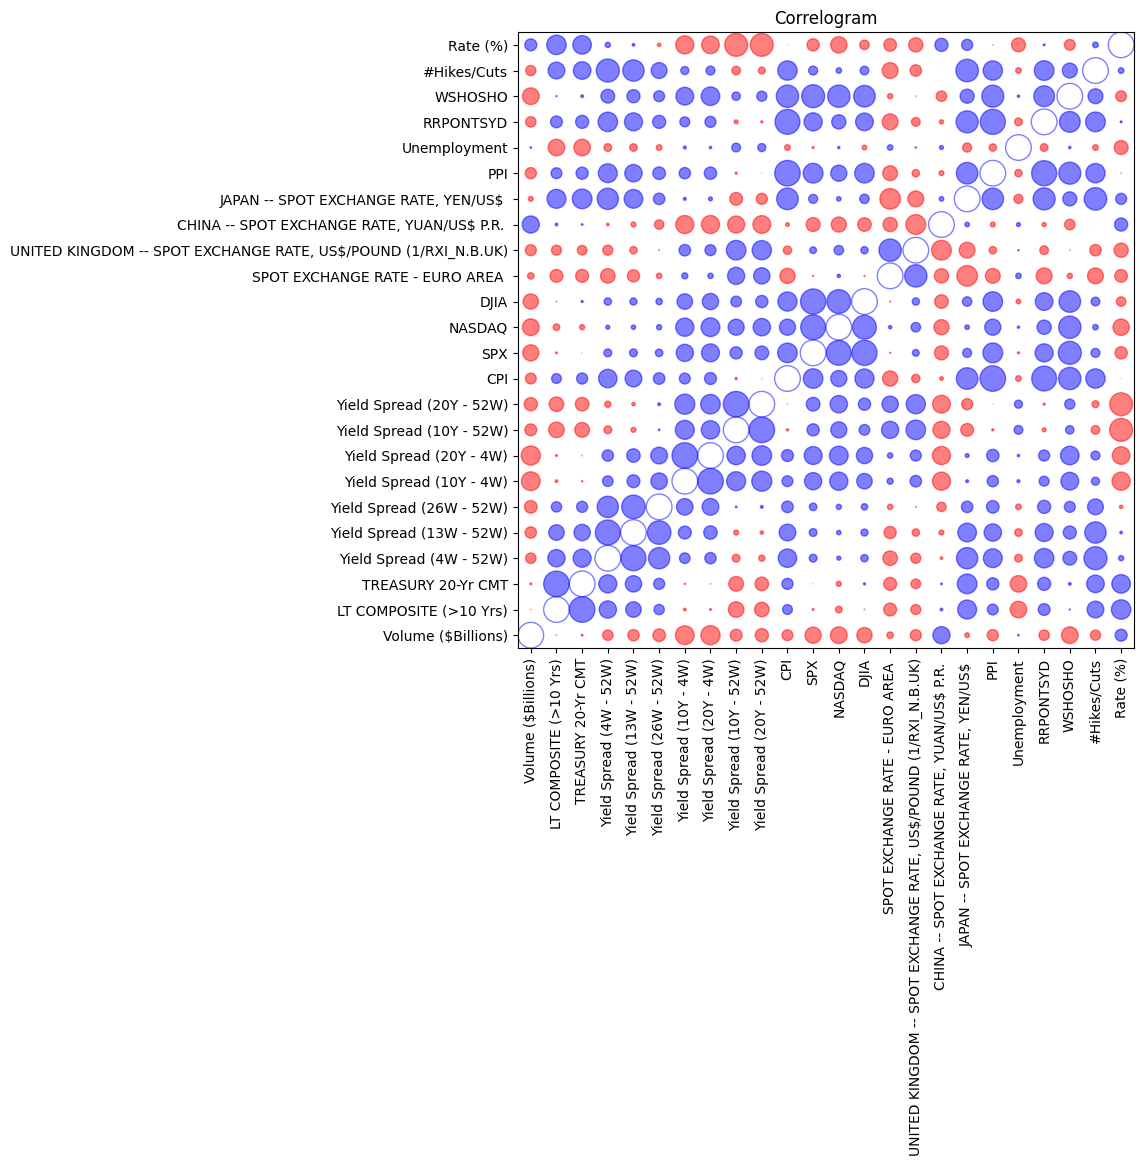

In [363]:
# display correlation matrix visually

# Initialize figure
plt.figure(figsize=(8, 8))
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        # Determine the color based on positive or negative correlation
        color = 'blue' if corr.iloc[i, j] > 0 else 'red'

        # don't fill in circles on the diagonal
        fill = not( i == j )

        # Plot the circle with size corresponding to the absolute value of correlation
        plt.gca().add_patch(plt.Circle((j, i),
                                       0.5 * np.abs(corr.iloc[i, j]),
                                       color=color,
                                       edgecolor=color,
                                       fill=fill,
                                       alpha=0.5))



plt.xlim(-0.5, len(corr.columns) - 0.5)
plt.ylim(-0.5, len(corr.columns) - 0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.title('Correlogram')
plt.show()

# Model Setup

In [364]:
# Apply MinMaxScaler to all features
scaler = MinMaxScaler()

# Fit and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test data
X_test = scaler.transform(X_test)

# Scale the target variable (Rate %)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

In [365]:
# Model definition

def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 30

# Create sequences for training data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)

# Create sequences for testing data
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

# Check the shapes of the sequences
print(f"Training sequences: {X_train_seq.shape}, Training targets: {y_train_seq.shape}")
print(f"Testing sequences: {X_test_seq.shape}, Testing targets: {y_test_seq.shape}")


Training sequences: (1144, 30, 23), Training targets: (1144,)
Testing sequences: (337, 30, 23), Testing targets: (337,)


<ipython-input-365-ef8dbe51145f>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



# Model Training

##Baseline Model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.1858 - val_loss: 1.8700
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1087 - val_loss: 1.9390
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0874 - val_loss: 1.1251
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0630 - val_loss: 1.1371
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0681 - val_loss: 1.1057
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0473 - val_loss: 0.5142
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0666 - val_loss: 0.5217
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0596 - val_loss: 0.5963
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0443 - val_loss: 0.8118
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0471 - val_loss: 0.5597
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0337 - val_loss: 0.4280
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0423 - val_loss: 0.621

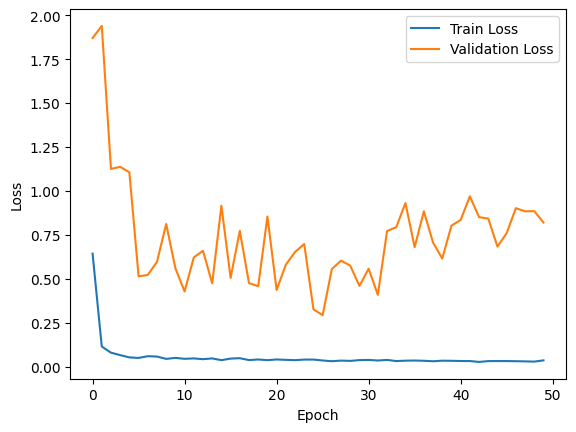

In [366]:
# Build the baseline LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=50, validation_data=(X_test_seq, y_test_seq))

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Add Early Stopping & Regularization

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.0545 - val_loss: 4.2655
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3245 - val_loss: 3.1315
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0042 - val_loss: 1.3964
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8123 - val_loss: 1.6528
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6874 - val_loss: 1.2751
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5694 - val_loss: 1.2878
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5098 - val_loss: 1.5508
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4441 - val_loss: 1.1183
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3883 - val_loss: 0.9273
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3350 - val_loss: 1.1681
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3092 - val_loss: 1.0100
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2899 - val_l

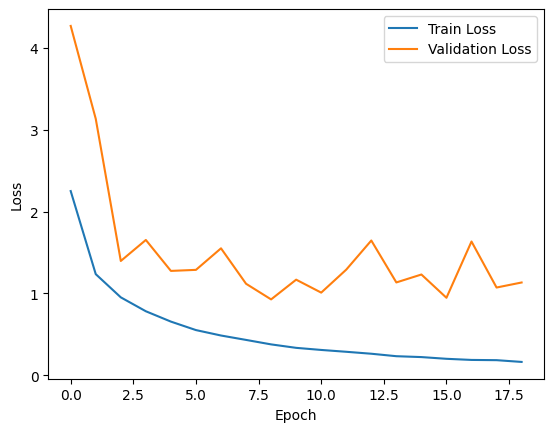

In [367]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(25, kernel_regularizer=l2(0.01)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Optuna Hyperparameter Tuning

In [370]:
def objective(trial):
    # Hyperparameters to tune
    n_lstm_units = trial.suggest_int('n_lstm_units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-5, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 32, 64)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(n_lstm_units, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_lstm_units, return_sequences=False, kernel_regularizer=l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25, kernel_regularizer=l2(l2_regularization)))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')])

    # Evaluate the model
    val_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    return val_loss

# Create the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

# Plot optimization history
optuna.visualization.plot_optimization_history(study)

[I 2024-08-12 22:27:43,858] A new study created in memory with name: no-name-73d5a86c-8a90-444d-8b1a-9c9e9b0e253c


Epoch 1/50


<ipython-input-370-32a96e62d028>:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-370-32a96e62d028>:7: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.



72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.0930 - val_loss: 0.8756
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5780 - val_loss: 2.1656
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3657 - val_loss: 0.9941
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2477 - val_loss: 0.9413
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2066 - val_loss: 1.7351
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1550 - val_loss: 0.9285
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1436 - val_loss: 1.2798
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1208 - val_loss: 1.7170
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1126 - val_loss: 1.5587
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1072 - val_loss: 0.7295
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0934 - val_loss: 1.4453
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1277 - val_loss: 1.999

[I 2024-08-12 22:28:02,591] Trial 0 finished with value: 0.18747912347316742 and parameters: {'n_lstm_units': 116, 'dropout_rate': 0.458882192687534, 'l2_regularization': 0.007711321691562105, 'learning_rate': 0.002941149941968597, 'batch_size': 16}. Best is trial 0 with value: 0.18747912347316742.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.7408 - val_loss: 15.5184
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1524 - val_loss: 6.1698
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5062 - val_loss: 3.8917
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3626 - val_loss: 2.8027
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2839 - val_loss: 2.7126
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1552 - val_loss: 2.3802
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0586 - val_loss: 2.1487
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9885 - val_loss: 2.0006
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9090 - val_loss: 1.9185
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8501 - val_loss: 1.9085
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7722 - val_loss: 1.7487
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6976 - val

[I 2024-08-12 22:28:36,345] Trial 1 finished with value: 0.5876461863517761 and parameters: {'n_lstm_units': 192, 'dropout_rate': 0.26378513148305904, 'l2_regularization': 0.0063927610791914245, 'learning_rate': 2.7576299167838697e-05, 'batch_size': 16}. Best is trial 0 with value: 0.18747912347316742.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.7768 - val_loss: 12.3665
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5902 - val_loss: 4.2200
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2243 - val_loss: 2.4652
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1790 - val_loss: 1.8818
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1792 - val_loss: 1.3898
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1668 - val_loss: 1.0317
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1798 - val_loss: 1.0701
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1688 - val_loss: 0.7632
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1547 - val_loss: 0.6769
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1648 - val_loss: 0.6144
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1496 - val_loss: 0.5524
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1468 - val_

[I 2024-08-12 22:28:52,188] Trial 2 finished with value: 0.4360700249671936 and parameters: {'n_lstm_units': 59, 'dropout_rate': 0.20991491431713744, 'l2_regularization': 0.0006444237671912258, 'learning_rate': 9.725088915015879e-05, 'batch_size': 16}. Best is trial 0 with value: 0.18747912347316742.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.2108 - val_loss: 0.5394
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4187 - val_loss: 0.4641
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3041 - val_loss: 0.3722
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2602 - val_loss: 0.4966
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2216 - val_loss: 1.0204
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1961 - val_loss: 0.4081
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1511 - val_loss: 0.4294
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1422 - val_loss: 0.9471
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1431 - val_loss: 0.8635
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1182 - val_loss: 0.5919
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0929 - val_loss: 0.1096
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1168 - val_l

[I 2024-08-12 22:29:08,185] Trial 3 finished with value: 0.1095583438873291 and parameters: {'n_lstm_units': 183, 'dropout_rate': 0.276373228447246, 'l2_regularization': 0.0019387804010001523, 'learning_rate': 0.0010580944330054565, 'batch_size': 16}. Best is trial 3 with value: 0.1095583438873291.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.1049 - val_loss: 1.9468
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3098 - val_loss: 0.9458
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2011 - val_loss: 0.5982
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1700 - val_loss: 0.9231
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1530 - val_loss: 0.4540
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1370 - val_loss: 0.6692
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0909 - val_loss: 0.9183
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0920 - val_loss: 1.2201
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0775 - val_loss: 0.8483
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0713 - val_loss: 2.0861
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0726 - val_loss: 1.7163
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0834 - val_l

[I 2024-08-12 22:29:29,187] Trial 4 finished with value: 0.4382651448249817 and parameters: {'n_lstm_units': 87, 'dropout_rate': 0.3438336705050639, 'l2_regularization': 0.0025911300400026506, 'learning_rate': 0.00550007516898303, 'batch_size': 16}. Best is trial 3 with value: 0.1095583438873291.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.3711 - val_loss: 1.4558
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2661 - val_loss: 1.0677
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0586 - val_loss: 0.9098
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9107 - val_loss: 0.8120
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7885 - val_loss: 0.6956
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7077 - val_loss: 0.6434
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6248 - val_loss: 0.5725
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5815 - val_loss: 0.5234
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5101 - val_loss: 0.4784
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4912 - val_loss: 0.4312
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4369 - val_loss: 0.4198
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4300 - val_l

[I 2024-08-12 22:29:48,909] Trial 5 finished with value: 0.2617017328739166 and parameters: {'n_lstm_units': 153, 'dropout_rate': 0.2399122530278839, 'l2_regularization': 0.004278581071551617, 'learning_rate': 0.0001674191980622667, 'batch_size': 16}. Best is trial 3 with value: 0.1095583438873291.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3769

[I 2024-08-12 22:29:52,030] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3467

[I 2024-08-12 22:29:55,145] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2056

[I 2024-08-12 22:29:58,231] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.8956 - val_loss: 0.9536
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3019 - val_loss: 1.1212
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2241 - val_loss: 0.7701
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2087 - val_loss: 0.7658
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1760 - val_loss: 0.6474
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2083 - val_loss: 0.7209
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1389 - val_loss: 0.8305
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1412 - val_loss: 0.6600
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1106 - val_loss: 0.5685
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1157 - val_loss: 1.0896
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1058 - val_loss: 0.8337
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1111 - val_l

[I 2024-08-12 22:30:09,962] Trial 9 pruned. Trial was pruned at epoch 14.


Epoch 1/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9866

[I 2024-08-12 22:30:13,076] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7298

[I 2024-08-12 22:30:16,175] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5906

[I 2024-08-12 22:30:19,242] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.7242 - val_loss: 1.2014
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6364 - val_loss: 1.1407
Epoch 3/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4762

[I 2024-08-12 22:30:23,497] Trial 13 pruned. Trial was pruned at epoch 2.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3882

[I 2024-08-12 22:30:26,553] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8992

[I 2024-08-12 22:30:29,628] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.8741 - val_loss: 0.6475
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5643 - val_loss: 0.9345
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3847 - val_loss: 1.1668
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2690 - val_loss: 0.2206
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2016 - val_loss: 0.6993
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1615 - val_loss: 0.3849
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1634 - val_loss: 0.5719
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1228 - val_loss: 0.9811
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1057 - val_loss: 0.6694
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0781 - val_loss: 2.7455
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0996 - val_loss: 0.7985
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0828 - val_l

[I 2024-08-12 22:30:40,508] Trial 16 finished with value: 0.22063806653022766 and parameters: {'n_lstm_units': 113, 'dropout_rate': 0.28792532342578114, 'l2_regularization': 0.005737203337666837, 'learning_rate': 0.0023525218856232308, 'batch_size': 16}. Best is trial 3 with value: 0.1095583438873291.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.9763 - val_loss: 1.4414
Epoch 2/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9127

[I 2024-08-12 22:30:44,193] Trial 17 pruned. Trial was pruned at epoch 1.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.7037 - val_loss: 0.6436
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0979 - val_loss: 0.5767
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0819 - val_loss: 0.2740
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0805 - val_loss: 0.2874
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0678 - val_loss: 0.4043
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0591 - val_loss: 0.1055
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0849 - val_loss: 0.8797
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0599 - val_loss: 0.3044
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0802 - val_loss: 0.2564
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0522 - val_loss: 0.4254
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0499 - val_loss: 0.5540
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0771 - val_l

[I 2024-08-12 22:30:56,081] Trial 18 finished with value: 0.1055489256978035 and parameters: {'n_lstm_units': 94, 'dropout_rate': 0.20882621889820735, 'l2_regularization': 0.0001144734320006266, 'learning_rate': 0.0007050911829162126, 'batch_size': 16}. Best is trial 18 with value: 0.1055489256978035.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6795

[I 2024-08-12 22:30:59,172] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9999 - val_loss: 0.5085
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1458 - val_loss: 0.2709
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1030 - val_loss: 0.4994
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1045 - val_loss: 0.3350
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0894 - val_loss: 0.2799
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0890 - val_loss: 0.4202
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0869 - val_loss: 0.2032
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0875 - val_loss: 0.5191
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0940 - val_loss: 0.2042
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0845 - val_loss: 0.2385
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0888 - val_loss: 0.1580
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0714 - val_l

[I 2024-08-12 22:31:14,395] Trial 20 finished with value: 0.0880504623055458 and parameters: {'n_lstm_units': 91, 'dropout_rate': 0.23797162958675736, 'l2_regularization': 0.00023621982508687406, 'learning_rate': 0.0005891548328422772, 'batch_size': 16}. Best is trial 20 with value: 0.0880504623055458.


Epoch 1/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7166

[I 2024-08-12 22:31:17,537] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3619

[I 2024-08-12 22:31:20,574] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7288

[I 2024-08-12 22:31:23,640] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8835

[I 2024-08-12 22:31:26,713] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2050

[I 2024-08-12 22:31:29,827] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6222

[I 2024-08-12 22:31:32,889] Trial 26 pruned. Trial was pruned at epoch 0.


Epoch 1/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3062

[I 2024-08-12 22:31:35,937] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8567 - val_loss: 0.6089
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3146 - val_loss: 0.3530
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2641 - val_loss: 0.9307
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1978 - val_loss: 0.6227
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1829 - val_loss: 0.3970
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1326 - val_loss: 1.3422
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1527 - val_loss: 0.9880
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1241 - val_loss: 0.7481
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1029 - val_loss: 1.1726
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1112 - val_loss: 0.6589
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0745 - val_loss: 0.3694
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1156 - val_l

[I 2024-08-12 22:31:45,924] Trial 28 finished with value: 0.3529933989048004 and parameters: {'n_lstm_units': 92, 'dropout_rate': 0.20057794598895337, 'l2_regularization': 0.002095354870456347, 'learning_rate': 0.001711461478539695, 'batch_size': 16}. Best is trial 20 with value: 0.0880504623055458.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9447

[I 2024-08-12 22:31:49,006] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6218

[I 2024-08-12 22:31:52,103] Trial 30 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2030

[I 2024-08-12 22:31:55,228] Trial 31 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1998

[I 2024-08-12 22:31:58,389] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1486

[I 2024-08-12 22:32:01,475] Trial 33 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2823

[I 2024-08-12 22:32:04,560] Trial 34 pruned. Trial was pruned at epoch 0.


Epoch 1/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9119

[I 2024-08-12 22:32:07,680] Trial 35 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0245

[I 2024-08-12 22:32:10,724] Trial 36 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0671

[I 2024-08-12 22:32:13,811] Trial 37 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6275

[I 2024-08-12 22:32:16,896] Trial 38 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7738

[I 2024-08-12 22:32:20,052] Trial 39 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6720

[I 2024-08-12 22:32:23,139] Trial 40 pruned. Trial was pruned at epoch 0.


Epoch 1/50
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9104

[I 2024-08-12 22:32:26,365] Trial 41 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0799

[I 2024-08-12 22:32:29,455] Trial 42 pruned. Trial was pruned at epoch 0.


Epoch 1/50
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6010

[I 2024-08-12 22:32:37,622] Trial 43 pruned. Trial was pruned at epoch 0.


Epoch 1/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2197

[I 2024-08-12 22:32:40,940] Trial 44 pruned. Trial was pruned at epoch 0.


Epoch 1/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7697

[I 2024-08-12 22:32:44,244] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0703

[I 2024-08-12 22:32:47,418] Trial 46 pruned. Trial was pruned at epoch 0.


Epoch 1/50
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3115

[I 2024-08-12 22:32:50,596] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8554

[I 2024-08-12 22:32:53,722] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.3894 - val_loss: 0.5887
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5758 - val_loss: 0.9193
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4413 - val_loss: 0.9080
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3712 - val_loss: 0.3586
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2893 - val_loss: 0.8821
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2519 - val_loss: 0.7645
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2248 - val_loss: 0.5910
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2449 - val_loss: 0.6626
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1876 - val_loss: 0.6297
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1824 - val_loss: 0.4460
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1582 - val_loss: 0.2727
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1651 - val_l

[I 2024-08-12 22:33:09,509] Trial 49 finished with value: 0.2727663516998291 and parameters: {'n_lstm_units': 157, 'dropout_rate': 0.2826148660029705, 'l2_regularization': 0.0025020549342049236, 'learning_rate': 0.0006367892598127039, 'batch_size': 16}. Best is trial 20 with value: 0.0880504623055458.


Best hyperparameters:  {'n_lstm_units': 91, 'dropout_rate': 0.23797162958675736, 'l2_regularization': 0.00023621982508687406, 'learning_rate': 0.0005891548328422772, 'batch_size': 16}


##Using the best params - Prediction & Evaluation

In [371]:
best_params = {
    'n_lstm_units': 91,
    'dropout_rate': 0.23797162958675736,
    'l2_regularization': 0.00023621982508687406,
    'learning_rate': 0.0005891548328422772,
    'batch_size': 16
}

# Build the best model using the best hyperparameters
best_model = Sequential()
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=False, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(25, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dense(1))

# Compile the best model
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

# Train the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model.fit(X_train_seq, y_train_seq, batch_size=best_params['batch_size'], epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Calculate metrics on the training data
y_train_pred = best_model.predict(X_train_seq)
y_train_pred_original = target_scaler.inverse_transform(y_train_pred)
y_train_original = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))

rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
mae_train = mean_absolute_error(y_train_original, y_train_pred_original)
mse_train = mean_squared_error(y_train_original, y_train_pred_original)
r_squared_train = r2_score(y_train_original, y_train_pred_original)

print(f'Training RMSE: {rmse_train}')
print(f'Training MAE: {mae_train}')
print(f'Training MSE: {mse_train}')
print(f'Training R-squared: {r_squared_train}')

# Predict using the best model on the test data
y_pred = best_model.predict(X_test_seq)

# Inverse transform the predictions and the true test values
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate evaluation metrics on the test data
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r_squared = r2_score(y_test_original, y_pred_original)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')
print(f'Test R-squared: {r_squared}')

n = len(y_test_seq)  # Number of data points
p = X_test_seq.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print(f'Adjusted Test R-squared: {adjusted_r2}')


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0174 - val_loss: 0.7611
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1264 - val_loss: 0.1018
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1247 - val_loss: 0.1433
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0885 - val_loss: 0.3175
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0891 - val_loss: 0.1921
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1193 - val_loss: 0.3061
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0782 - val_loss: 0.2038
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0845 - val_loss: 0.1806
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0751 - val_loss: 0.2888
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0746 - val_loss: 0.1624
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0747 - val_loss: 0.5331
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0728 - val_l

# Feature Importance

Method 1: Tree-Based Approach

While random forest is a straight-forward approach to capture non-linearity between features and tagret variable, one of its underlying assumptions is that each observation is independent and therefore does not account for the temporal dependecies of our data.

In [317]:
X = df_final2.drop(columns=['Rate (%)'])  # Features
y = df_final2['Rate (%)']  # Target

# Fit a Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n")
feature_importance_df.sort_values(by='Importance', ascending=False)


Feature Importances:



,Feature,Importance
18,PPI,0.776122
8,Yield Spread (10Y - 52W),0.170425
21,WSHOSHO,0.026594
9,Yield Spread (20Y - 52W),0.010446
1,LT COMPOSITE (>10 Yrs),0.004215
12,NASDAQ,0.002412
22,#Hikes/Cuts,0.002392
10,CPI,0.001328
2,TREASURY 20-Yr CMT,0.001056
14,SPOT EXCHANGE RATE - EURO AREA,0.000999


Method 2: Use SHAP (SHapley Additive exPlanations) to understand which features contribute most to the predictions, especially for time-series data using LSTM.

NOTE: because SHAP expects the input to be in 2D format, df need to be reshared first, resulting in large number of features. To handle this high-dimensional data, we also applied PCA to capture the majority of the variance in the data.

X_train_2d.shape: (1144, 690)
X_test_2d.shape: (337, 690)
X_train_pca.shape: (1144, 100)
X_test_pca.shape: (337, 100)
data_reshaped shape: (1144, 30, 23)
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 0/337 [00:00<?, ?it/s]

data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 87 iterations, alpha=1.992e-05, previous alpha=1.992e-05, with an active set of 46 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.267e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=4.643e-03, previous alpha=4.531e-03, with an active set of 23 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=1.503e-05, with an active set of 48 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 63 iterations, alpha=1.503e-05, previous alpha=1.448e-05, with an active set of 48 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.595e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.402e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.094e-03, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_it

data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=1.229e-03, previous alpha=1.209e-03, with an active set of 29 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.916e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.586e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterations, alpha=1.830e-02, previous alpha=1.830e-02, with an active set of 40 regressors.

shap_values shape: (337, 100, 1)
X_test_pca shape: (337, 100)
Error during plotting: only integer scalar arrays can be converted to a scalar index
shap_values[0] shape: (100, 1)
shap_values[1] shape: (100, 1)
shap_values[2] shape: (100, 1)
shap_values[3] shape: (100, 1)
shap_values[4] shape: (100, 1)
shap_values[5] shape: (100, 1)
shap_values[6] shape: (100, 1)
shap_values[7] shape: (100, 1)
shap_values[8] shape: (100, 1)
shap_values[9] shape: (100, 1)
shap_values[10] shape: (100, 1)
shap_values[11] shape: (100, 1)
shap_values[12] shape: (100, 1)
shap_values[13] shape: (100, 1)
shap_values[14] shape: (100, 1)
shap_values[15] shape: (100, 1)
shap_values[16] shape: (100, 1)
shap_values[17] shape: (100, 1)
shap_values[18] shape: (100, 1)
shap_values[19] shape: (100, 1)
shap_values[20] shape: (100, 1)
shap_values[21] shape: (100, 1)
shap_values[22] shape: (100, 1)
shap_values[23] shape: (100, 1)
shap_values[24] shape: (100, 1)
shap_values[25] shape: (100, 1)
shap_values[26] shape: (100, 1)

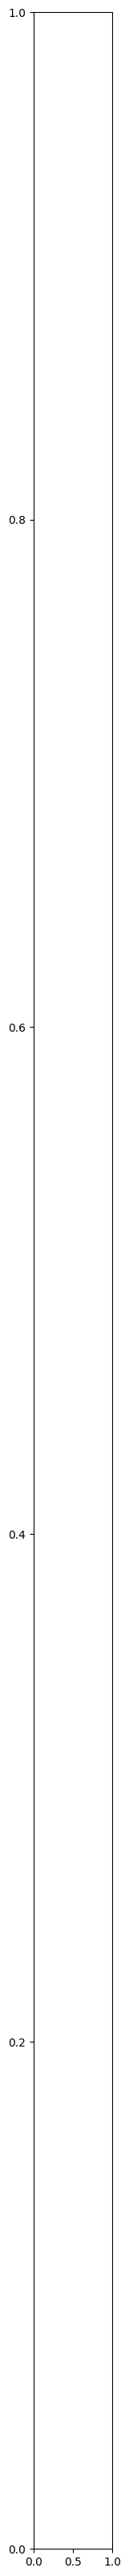

In [323]:
# Flatten the 3D data to 2D for SHAP explainer
X_train_2d = X_train_seq.reshape((X_train_seq.shape[0], -1))
X_test_2d = X_test_seq.reshape((X_test_seq.shape[0], -1))

# Verify the flattened shapes
print(f'X_train_2d.shape: {X_train_2d.shape}')
print(f'X_test_2d.shape: {X_test_2d.shape}')

# Apply PCA to reduce dimensionality
n_components = 100  # Adjust n_components as needed
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

# Verify the PCA shapes
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(f'X_test_pca.shape: {X_test_pca.shape}')

# Define the prediction function
def predict_function(data):
    data_reconstructed = pca.inverse_transform(data)
    # The reshaping logic here should be: (num_samples, seq_length, num_features_per_time_step)
    num_features_per_time_step = data_reconstructed.shape[1] // seq_length
    data_reshaped = data_reconstructed.reshape((data.shape[0], seq_length, num_features_per_time_step))
    print(f'data_reshaped shape: {data_reshaped.shape}')  # Print to verify
    return best_model.predict(data_reshaped)

# Use KernelExplainer for SHAP values with reduced data
explainer = shap.KernelExplainer(predict_function, X_train_pca)

# Calculate SHAP values using the test data
shap_values = explainer.shap_values(X_test_pca, nsamples=100)

# Save intermediate results to avoid recomputation
np.save('shap_values.npy', shap_values)
np.save('X_test_pca.npy', X_test_pca)

# Ensure SHAP initialization
shap.initjs()

# Debug: Print shapes to verify consistency
print(f'shap_values shape: {np.array(shap_values).shape}')
print(f'X_test_pca shape: {X_test_pca.shape}')

# Plot SHAP values for feature importance
try:
    shap.summary_plot(
        shap_values,
        X_test_pca,
        feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])],
        max_display=50,
        plot_type='bar'
    )
except TypeError as e:
    print(f"Error during plotting: {e}")
    # Debugging info
    for i, shap_value in enumerate(shap_values):
        print(f'shap_values[{i}] shape: {shap_value.shape}')
    print(f'X_test_pca shape: {X_test_pca.shape}')

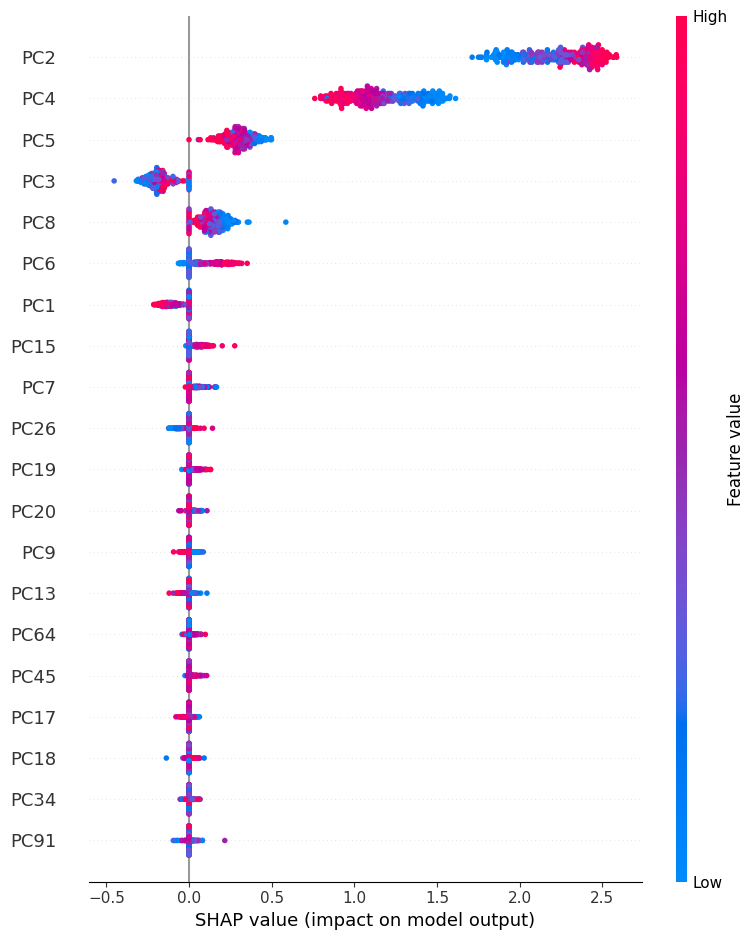

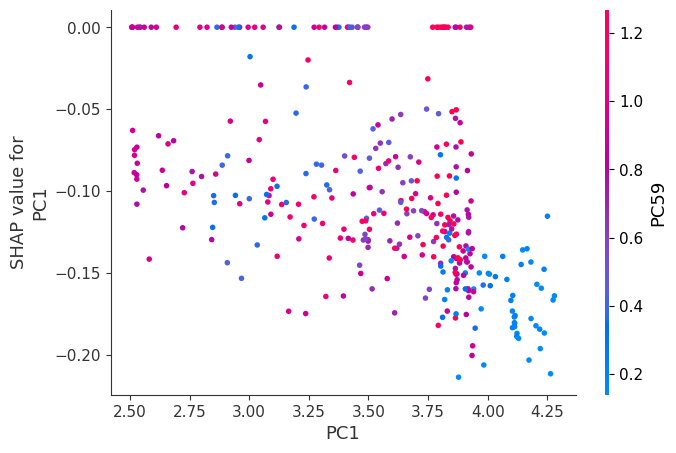

In [324]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Reshape shap_values
shap_values_reshaped = np.squeeze(shap_values)

# Plotting summary plot
shap.summary_plot(shap_values_reshaped, X_test_pca, feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Plotting a dependence plot for the first principal component
shap.dependence_plot(0, shap_values_reshaped, X_test_pca, feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])


In [325]:
# Generate appropriate column names
original_feature_names = df_final2.columns[1:]  # Excluding 'Rate (%)'
time_steps = seq_length
column_names = [f'{feature}_t{t}' for feature in original_feature_names for t in range(time_steps)]

# Create a DataFrame to hold the components and their corresponding feature names
components_df = pd.DataFrame(pca.components_, columns=column_names)

# Print the DataFrame to see the feature names corresponding to each principal component
print(components_df)

# Function to get the top 5 contributing features for each principal component
def get_top_features(components_df, pc_num, top_n=5):
    """
    Get the top N features for a given principal component.

    :param components_df: DataFrame of PCA components.
    :param pc_num: Principal component number (1-based index).
    :param top_n: Number of top features to retrieve.
    :return: Series of top N features and their corresponding weights.
    """
    pc_series = components_df.iloc[pc_num - 1]  # Convert to 0-based index
    top_features = pc_series.abs().sort_values(ascending=False).head(top_n)
    return top_features

# Example: Top 5 contributing features for the first principal component (PC1)
top_features_pc1 = get_top_features(components_df, 1)
print("Top 5 features for PC1:")
print(top_features_pc1)

# Example: Top 5 contributing features for the second principal component (PC2)
top_features_pc2 = get_top_features(components_df, 2)
print("Top 5 features for PC2:")
print(top_features_pc2)

    Volume ($Billions)_t0  Volume ($Billions)_t1  Volume ($Billions)_t2  \
0               -0.030861               0.008058               0.010920   
1                0.021735               0.051471               0.049858   
2               -0.046922               0.053550               0.053085   
3               -0.006240              -0.035398              -0.035200   
4                0.064944              -0.051844              -0.052438   
..                    ...                    ...                    ...   
95               0.135312              -0.008659              -0.006848   
96               0.057212               0.006394               0.003442   
97              -0.053939              -0.001009               0.002857   
98              -0.064314              -0.026925              -0.022948   
99               0.053831               0.027665               0.024959   

    Volume ($Billions)_t3  Volume ($Billions)_t4  ...  #Hikes/Cuts_t25  \
0                0.027104

# Account for Seasonality

In [326]:
data = df_final2.copy()

In [327]:
# Create seasonal features

def create_lagged_features(df, lag=1):
    df_lagged = df.copy()
    for col in df.columns:
        for i in range(1, lag + 1):
            df_lagged[f'{col}_lag_{i}'] = df[col].shift(i)
    return df_lagged

# Create differenced features
def create_differenced_features(df, lag=1):
    df_diff = df.copy()
    for col in df.columns:
        df_diff[f'{col}_diff_{lag}'] = df[col].diff(lag)
    return df_diff

# Apply lag and differencing
lag = 12  # to align with the ARIMA seasonal cycle
data_lagged = create_lagged_features(data, lag=lag)
data_differenced = create_differenced_features(data_lagged, lag=lag)

# Drop rows with NaN values created by lagging/differencing
data_prepared = data_differenced.dropna()

# Ensure the target variable is not included in the lagged/differenced features
target_variable = 'Rate (%)'
feature_columns = [col for col in data_prepared.columns if col != target_variable]

# Prepare the final dataset
X = data_prepared[feature_columns].values
y = data_prepared[target_variable].values


<ipython-input-327-df652e952f5b>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-327-df652e952f5b>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-327-df652e952f5b>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-327-df652e952f5b>:7: PerformanceWarning:

In [372]:
# Split into training and test sets using boolean indexing with date strings
train_data = data_prepared.loc[:'2022-12-31']
test_data = data_prepared.loc['2023-01-01':]

# Separate features and target variable for training and testing sets
X_train = train_data[feature_columns].values
y_train = train_data[target_variable].values
X_test = test_data[feature_columns].values
y_test = test_data[target_variable].values

# Scaling value
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)
print(f"Training sequences: {X_train_seq.shape}, Training targets: {y_train_seq.shape}")
print(f"Testing sequences: {X_test_seq.shape}, Testing targets: {y_test_seq.shape}")

Training sequences: (1120, 30, 623), Training targets: (1120, 1)
Testing sequences: (337, 30, 623), Testing targets: (337, 1)


In [373]:
def objective(trial):
    # Hyperparameters to tune
    n_lstm_units = trial.suggest_int('n_lstm_units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-5, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 32, 64)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(n_lstm_units, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_lstm_units, return_sequences=False, kernel_regularizer=l2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25, kernel_regularizer=l2(l2_regularization)))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')])

    # Evaluate the model
    val_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    return val_loss

# Create the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

# Plot optimization history
optuna.visualization.plot_optimization_history(study)

[I 2024-08-12 22:35:00,031] A new study created in memory with name: no-name-a8d811f4-128e-46d5-ad07-94a6e8b38de6
<ipython-input-373-32a96e62d028>:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-373-32a96e62d028>:7: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning:

The distribution is specified by [16, 32] and step=64, but the range is not divisible by `step`. It will be replaced by [16, 16].

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.8898 - val_loss: 2.5513
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7051 - val_loss: 0.9356
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6772 - val_loss: 0.7170
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4144 - val_loss: 0.3985
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2725 - val_loss: 0.3058
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1979 - val_loss: 0.2675
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1454 - val_loss: 0.2852
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1094 - val_loss: 0.2074
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1095 - val_loss: 0.1777
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0639 - val_loss: 0.1551
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0513 - val_loss: 0.2383
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0523 - val_l

[I 2024-08-12 22:35:16,134] Trial 0 finished with value: 0.03364850953221321 and parameters: {'n_lstm_units': 179, 'dropout_rate': 0.28464661864671914, 'l2_regularization': 0.008927386062375331, 'learning_rate': 0.005689446246181219, 'batch_size': 16}. Best is trial 0 with value: 0.03364850953221321.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.5879 - val_loss: 3.9894
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4891 - val_loss: 3.7825
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4343 - val_loss: 3.6532
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3812 - val_loss: 3.5838
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3278 - val_loss: 3.5010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2735 - val_loss: 3.4270
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2218 - val_loss: 3.3400
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1708 - val_loss: 3.2727
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1178 - val_loss: 3.2131
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0667 - val_loss: 3.1517
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0156 - val_loss: 3.0961
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9637 - val_l

[I 2024-08-12 22:35:46,719] Trial 1 finished with value: 1.4284634590148926 and parameters: {'n_lstm_units': 77, 'dropout_rate': 0.21218425946064745, 'l2_regularization': 0.006091034948644417, 'learning_rate': 1.0834391625992633e-05, 'batch_size': 16}. Best is trial 0 with value: 0.03364850953221321.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.4533 - val_loss: 2.5562
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2967 - val_loss: 1.6692
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4975 - val_loss: 1.1546
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9918 - val_loss: 0.7660
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6799 - val_loss: 0.5454
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4840 - val_loss: 0.3971
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3595 - val_loss: 0.3160
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2746 - val_loss: 0.2703
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2131 - val_loss: 0.2044
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1695 - val_loss: 0.1663
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1375 - val_loss: 0.1427
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1099 - val_l

[I 2024-08-12 22:36:15,901] Trial 2 finished with value: 0.01340881921350956 and parameters: {'n_lstm_units': 120, 'dropout_rate': 0.4920253109069875, 'l2_regularization': 0.004725263963665374, 'learning_rate': 0.00029488543361101715, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.3772 - val_loss: 5.9286
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6507 - val_loss: 5.2187
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9926 - val_loss: 4.5634
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3915 - val_loss: 4.0578
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8500 - val_loss: 3.5156
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3660 - val_loss: 3.1023
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9406 - val_loss: 2.6998
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5647 - val_loss: 2.3424
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2370 - val_loss: 2.0509
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9513 - val_loss: 1.7799
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7025 - val_loss: 1.5719
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4871 - val_l

[I 2024-08-12 22:36:48,167] Trial 3 finished with value: 0.029769238084554672 and parameters: {'n_lstm_units': 100, 'dropout_rate': 0.4272616504429917, 'l2_regularization': 0.009386681859097657, 'learning_rate': 7.866143422901875e-05, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.5081 - val_loss: 0.9604
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6632 - val_loss: 0.5308
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2695 - val_loss: 0.2269
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1415 - val_loss: 0.1351
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0837 - val_loss: 0.2036
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0506 - val_loss: 0.1470
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0320 - val_loss: 0.1016
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0216 - val_loss: 0.1240
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0155 - val_loss: 0.1605
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159 - val_loss: 0.0958
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - val_loss: 0.1076
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_l

[I 2024-08-12 22:37:02,837] Trial 4 finished with value: 0.043899282813072205 and parameters: {'n_lstm_units': 61, 'dropout_rate': 0.47410853680200327, 'l2_regularization': 0.009805431361066732, 'learning_rate': 0.001971755995095698, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.6154 - val_loss: 1.0152
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6881 - val_loss: 0.5110
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3430 - val_loss: 0.3617
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2257 - val_loss: 0.2703
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1682 - val_loss: 0.3080
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1052 - val_loss: 0.2185
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0722 - val_loss: 0.3318
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0607 - val_loss: 0.1589
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0445 - val_loss: 0.1185
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0274 - val_loss: 0.1939
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0837 - val_loss: 0.0827
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0232 - val_l

[I 2024-08-12 22:37:21,368] Trial 5 finished with value: 0.027506472542881966 and parameters: {'n_lstm_units': 96, 'dropout_rate': 0.3353989890549446, 'l2_regularization': 0.006809809810410801, 'learning_rate': 0.004125984955628251, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
66/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1622

[I 2024-08-12 22:37:24,445] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0279

[I 2024-08-12 22:37:27,520] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.4938

[I 2024-08-12 22:37:30,676] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0141

[I 2024-08-12 22:37:33,709] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.0552 - val_loss: 1.3806
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1923 - val_loss: 0.9709
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8313 - val_loss: 0.6816
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6068 - val_loss: 0.5747
Epoch 5/50
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4638

[I 2024-08-12 22:37:39,049] Trial 10 pruned. Trial was pruned at epoch 4.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.6277 - val_loss: 2.0075
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5997 - val_loss: 1.1369
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9163 - val_loss: 0.8219
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5989 - val_loss: 0.5236
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4234 - val_loss: 0.4115
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3144 - val_loss: 0.2996
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2440 - val_loss: 0.2763
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1915 - val_loss: 0.2088
Epoch 9/50
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1540

[I 2024-08-12 22:37:46,603] Trial 11 pruned. Trial was pruned at epoch 8.


Epoch 1/50
64/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3635

[I 2024-08-12 22:37:49,688] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.4683 - val_loss: 1.5763
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3138 - val_loss: 0.9598
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7996 - val_loss: 0.6221
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5382 - val_loss: 0.4918
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3849 - val_loss: 0.3486
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2877 - val_loss: 0.2588
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2223 - val_loss: 0.2142
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1755 - val_loss: 0.1889
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1423 - val_loss: 0.1386
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1170 - val_loss: 0.1345
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0960 - val_loss: 0.1380
Epoch 12/50
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0804

[I 2024-08-12 22:37:58,854] Trial 13 pruned. Trial was pruned at epoch 11.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.3134 - val_loss: 1.4865
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7917 - val_loss: 0.5109
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3895 - val_loss: 0.3459
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2390 - val_loss: 0.3172
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1675 - val_loss: 0.2571
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1544 - val_loss: 0.4058
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1302 - val_loss: 0.1890
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0729 - val_loss: 0.1065
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0566 - val_loss: 0.0889
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0461 - val_loss: 0.1422
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0370 - val_loss: 0.0853
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0328 - val_l

[I 2024-08-12 22:38:20,054] Trial 14 finished with value: 0.03543376177549362 and parameters: {'n_lstm_units': 148, 'dropout_rate': 0.4073926586263374, 'l2_regularization': 0.003778463078501407, 'learning_rate': 0.003764838678389854, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3721 - val_loss: 0.3222
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2721 - val_loss: 0.3057
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2322 - val_loss: 0.2205
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1990 - val_loss: 0.2139
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1702 - val_loss: 0.1686
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1453 - val_loss: 0.1967
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1263 - val_loss: 0.1488
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1092 - val_loss: 0.1443
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0941 - val_loss: 0.1265
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0829 - val_loss: 0.0949
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0738 - val_loss: 0.1086
Epoch 12/50
63/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0662

[I 2024-08-12 22:38:29,132] Trial 15 pruned. Trial was pruned at epoch 11.


Epoch 1/50
64/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1295

[I 2024-08-12 22:38:32,201] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.4136 - val_loss: 1.0008
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6222 - val_loss: 0.5295
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2998 - val_loss: 0.3628
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1890 - val_loss: 0.2929
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1417 - val_loss: 0.4304
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1108 - val_loss: 0.1473
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0617 - val_loss: 0.1689
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0432 - val_loss: 0.1336
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0328 - val_loss: 0.0793
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0230 - val_loss: 0.0516
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0192 - val_loss: 0.0923
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0143 - val_l

[I 2024-08-12 22:38:54,805] Trial 17 finished with value: 0.017726777121424675 and parameters: {'n_lstm_units': 129, 'dropout_rate': 0.32252159944345304, 'l2_regularization': 0.005744121297220491, 'learning_rate': 0.0032639657487077032, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.5012 - val_loss: 1.7902
Epoch 2/50
64/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2959

[I 2024-08-12 22:38:58,526] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6020

[I 2024-08-12 22:39:01,607] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6895

[I 2024-08-12 22:39:04,708] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.9661 - val_loss: 1.1176
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8097 - val_loss: 0.6111
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4026 - val_loss: 0.5350
Epoch 4/50
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2622

[I 2024-08-12 22:39:09,661] Trial 21 pruned. Trial was pruned at epoch 3.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.6590 - val_loss: 1.0799
Epoch 2/50
67/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9815

[I 2024-08-12 22:39:13,344] Trial 22 pruned. Trial was pruned at epoch 1.


Epoch 1/50
63/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8359

[I 2024-08-12 22:39:16,465] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
66/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8235

[I 2024-08-12 22:39:19,585] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.9088 - val_loss: 1.2796
Epoch 2/50
67/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9205

[I 2024-08-12 22:39:23,285] Trial 25 pruned. Trial was pruned at epoch 1.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.9463 - val_loss: 1.9581
Epoch 2/50
63/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3736

[I 2024-08-12 22:39:26,882] Trial 26 pruned. Trial was pruned at epoch 1.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.2590 - val_loss: 1.6972
Epoch 2/50
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0592

[I 2024-08-12 22:39:30,589] Trial 27 pruned. Trial was pruned at epoch 1.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.4771 - val_loss: 0.9459
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6862 - val_loss: 0.5741
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4013 - val_loss: 0.3680
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2631 - val_loss: 0.3177
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1891 - val_loss: 0.2614
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1441 - val_loss: 0.1560
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1106 - val_loss: 0.1983
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0927 - val_loss: 0.1534
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0755 - val_loss: 0.1489
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0628 - val_loss: 0.1456
Epoch 11/50
64/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0539

[I 2024-08-12 22:39:39,469] Trial 28 pruned. Trial was pruned at epoch 10.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.5623 - val_loss: 1.7045
Epoch 2/50
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2583

[I 2024-08-12 22:39:43,127] Trial 29 pruned. Trial was pruned at epoch 1.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.1334 - val_loss: 1.4703
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7628 - val_loss: 0.5721
Epoch 3/50
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6984

[I 2024-08-12 22:39:47,428] Trial 30 pruned. Trial was pruned at epoch 2.


Epoch 1/50
67/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1300

[I 2024-08-12 22:39:50,517] Trial 31 pruned. Trial was pruned at epoch 0.


Epoch 1/50
62/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2542

[I 2024-08-12 22:39:53,602] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5037

[I 2024-08-12 22:39:56,714] Trial 33 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4480

[I 2024-08-12 22:39:59,796] Trial 34 pruned. Trial was pruned at epoch 0.


Epoch 1/50
62/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4767

[I 2024-08-12 22:40:02,932] Trial 35 pruned. Trial was pruned at epoch 0.


Epoch 1/50
64/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6960

[I 2024-08-12 22:40:05,988] Trial 36 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0457

[I 2024-08-12 22:40:09,193] Trial 37 pruned. Trial was pruned at epoch 0.


Epoch 1/50
67/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4086

[I 2024-08-12 22:40:12,365] Trial 38 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.0567 - val_loss: 0.7649
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5793 - val_loss: 0.3472
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2826 - val_loss: 0.3076
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1694 - val_loss: 0.1881
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1150 - val_loss: 0.1349
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0845 - val_loss: 0.1360
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0592 - val_loss: 0.1446
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0432 - val_loss: 0.1184
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0352 - val_loss: 0.0727
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0279 - val_loss: 0.1598
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0276 - val_loss: 0.1252
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0167 - val_l

[I 2024-08-12 22:40:28,245] Trial 39 finished with value: 0.01987069472670555 and parameters: {'n_lstm_units': 77, 'dropout_rate': 0.48272378208496786, 'l2_regularization': 0.004286410695539312, 'learning_rate': 0.001855198320608247, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6713 - val_loss: 0.3478
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2306 - val_loss: 0.2002
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1212 - val_loss: 0.2119
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0763 - val_loss: 0.1251
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0528 - val_loss: 0.1284
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0402 - val_loss: 0.0479
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0299 - val_loss: 0.1791
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0274 - val_loss: 0.0761
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0206 - val_loss: 0.0707
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0183 - val_loss: 0.0787
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.1113
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124 - val_l

[I 2024-08-12 22:40:48,601] Trial 40 finished with value: 0.016544226557016373 and parameters: {'n_lstm_units': 56, 'dropout_rate': 0.47811602625762767, 'l2_regularization': 0.0015453936917135761, 'learning_rate': 0.0021006702633692125, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3095 - val_loss: 0.2665
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1318 - val_loss: 0.1693
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0930 - val_loss: 0.1241
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0688 - val_loss: 0.0816
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0559 - val_loss: 0.0914
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0451 - val_loss: 0.0923
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0364 - val_loss: 0.1207
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0334 - val_loss: 0.0929
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0273 - val_loss: 0.0750
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0245 - val_loss: 0.0689
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0216 - val_loss: 0.0574
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0183 - val_l

[I 2024-08-12 22:41:06,264] Trial 41 finished with value: 0.021160069853067398 and parameters: {'n_lstm_units': 55, 'dropout_rate': 0.48371051855793423, 'l2_regularization': 0.00037783643496088447, 'learning_rate': 0.002345679969930184, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4084 - val_loss: 0.2815
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1790 - val_loss: 0.2649
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1363 - val_loss: 0.1808
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1076 - val_loss: 0.1409
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0882 - val_loss: 0.1392
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0728 - val_loss: 0.1020
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0617 - val_loss: 0.1065
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0519 - val_loss: 0.1223
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0451 - val_loss: 0.0865
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0416 - val_loss: 0.1003
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0352 - val_loss: 0.0589
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0320 - val_l

[I 2024-08-12 22:41:31,912] Trial 42 finished with value: 0.016704542562365532 and parameters: {'n_lstm_units': 52, 'dropout_rate': 0.48397259393794123, 'l2_regularization': 0.0004876097969841555, 'learning_rate': 0.001823070421202004, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.7911 - val_loss: 0.6063
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4283 - val_loss: 0.3915
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3094 - val_loss: 0.3303
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2326 - val_loss: 0.2498
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1793 - val_loss: 0.2112
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1444 - val_loss: 0.1515
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1165 - val_loss: 0.1632
Epoch 8/50
63/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0966

[I 2024-08-12 22:41:38,689] Trial 43 pruned. Trial was pruned at epoch 7.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6843 - val_loss: 0.5172
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4264 - val_loss: 0.3431
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2837 - val_loss: 0.2674
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1978 - val_loss: 0.2068
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1425 - val_loss: 0.1532
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1091 - val_loss: 0.1425
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0834 - val_loss: 0.0961
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0663 - val_loss: 0.1146
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0538 - val_loss: 0.0615
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0439 - val_loss: 0.0789
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0363 - val_loss: 0.0578
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0314 - val_l

[I 2024-08-12 22:41:57,030] Trial 44 finished with value: 0.01733585260808468 and parameters: {'n_lstm_units': 65, 'dropout_rate': 0.48537347711078976, 'l2_regularization': 0.001274845346776755, 'learning_rate': 0.0007793179845173566, 'batch_size': 16}. Best is trial 2 with value: 0.01340881921350956.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.7302 - val_loss: 0.5732
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4921 - val_loss: 0.5038
Epoch 3/50
64/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4124

[I 2024-08-12 22:42:07,324] Trial 45 pruned. Trial was pruned at epoch 2.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.5908 - val_loss: 0.8943
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6661 - val_loss: 0.4475
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3475 - val_loss: 0.3113
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2134 - val_loss: 0.2250
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1451 - val_loss: 0.1417
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1058 - val_loss: 0.1307
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0810 - val_loss: 0.1093
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0615 - val_loss: 0.1211
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0480 - val_loss: 0.0836
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0396 - val_loss: 0.0692
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0326 - val_loss: 0.1254
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0282 - val_l

[I 2024-08-12 22:42:39,604] Trial 46 finished with value: 0.007832921110093594 and parameters: {'n_lstm_units': 200, 'dropout_rate': 0.4966554779321418, 'l2_regularization': 0.0016046684773717284, 'learning_rate': 0.0010646072966715267, 'batch_size': 16}. Best is trial 46 with value: 0.007832921110093594.


Epoch 1/50
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7401

[I 2024-08-12 22:42:42,965] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/50
64/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5192

[I 2024-08-12 22:42:46,267] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.5182 - val_loss: 0.5907
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3909 - val_loss: 0.4159
Epoch 3/50
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3191

[I 2024-08-12 22:42:50,627] Trial 49 pruned. Trial was pruned at epoch 2.


Best hyperparameters:  {'n_lstm_units': 200, 'dropout_rate': 0.4966554779321418, 'l2_regularization': 0.0016046684773717284, 'learning_rate': 0.0010646072966715267, 'batch_size': 16}


In [374]:
best_params = {
    'n_lstm_units': 200,
    'dropout_rate': 0.4966554779321418,
    'l2_regularization': 0.0016046684773717284,
    'learning_rate': 0.0010646072966715267,
    'batch_size': 16
}

# Build the best model using the best hyperparameters
best_model = Sequential()
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=False, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(25, kernel_regularizer=l2(best_params['l2_regularization'])))
best_model.add(Dense(1))

# Compile the best model
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

# Train the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model.fit(X_train_seq, y_train_seq, batch_size=best_params['batch_size'], epochs=50, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Calculate metrics on the training data
y_train_pred = best_model.predict(X_train_seq)
y_train_pred_original = target_scaler.inverse_transform(y_train_pred)
y_train_original = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))

rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
mae_train = mean_absolute_error(y_train_original, y_train_pred_original)
mse_train = mean_squared_error(y_train_original, y_train_pred_original)
r_squared_train = r2_score(y_train_original, y_train_pred_original)

print(f'Training RMSE: {rmse_train}')
print(f'Training MAE: {mae_train}')
print(f'Training MSE: {mse_train}')
print(f'Training R-squared: {r_squared_train}')

# Predict using the best model on the test data
y_pred = best_model.predict(X_test_seq)

# Inverse transform the predictions and the true test values
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate evaluation metrics on the test data
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r_squared = r2_score(y_test_original, y_pred_original)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')
print(f'Test R-squared: {r_squared}')

n = len(y_test_seq)  # Number of data points
p = X_test_seq.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print(f'Adjusted Test R-squared: {adjusted_r2}')


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.9612 - val_loss: 1.3322
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0726 - val_loss: 0.8314
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7247 - val_loss: 0.5924
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5228 - val_loss: 0.4542
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3949 - val_loss: 0.4346
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3079 - val_loss: 0.3679
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2477 - val_loss: 0.3019
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2028 - val_loss: 0.2183
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1679 - val_loss: 0.1837
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1415 - val_loss: 0.1822
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1201 - val_loss: 0.1877
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1048 - val_l